In [1]:
# coding: utf-8
import re
import math
import csv
import sys
import os
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from obspy import UTCDateTime, Stream, Trace

%matplotlib inline

In [3]:
def unpackAfile(infile):

# == opening Afile ==
    b = os.path.getsize(infile)
    FH = open(infile, 'rb')
    line = FH.read(b)
    fileHeader = struct.unpack("<4s3h6bh6s", line[0:24])

    fileLength = fileHeader[3]
    port = fileHeader[10]
    # FirstStn = fileHeader[11][0:4].decode('ASCII').rstrip()
# =================================Header=================================

    portHeader = []
    for i in range(24, port * 32, 32):
        port_data = struct.unpack("<4s4s3sbh2b4s12b", line[i:i+32])
        portHeader.append(port_data)

# =================================Data===================================

    dataStartByte = 24+int(port)*32
    dataPoint = 3*int(port)*int(fileLength)*100
    times = int(port)*3*4
    data = []

    data = struct.unpack("<%di" % dataPoint, line[dataStartByte:dataStartByte + dataPoint*4])


    portHeader = np.array(portHeader)
    data = np.array(data)
    idata = data.reshape((3,port,fileLength*100),order='F')

#== write to obspy Stream --
    sttime = UTCDateTime(fileHeader[1], fileHeader[4], fileHeader[5], fileHeader[6], fileHeader[7], fileHeader[8], fileHeader[2])
    npts = fileHeader[3]*fileHeader[9]
    samp = fileHeader[9]
    afst = Stream()
    
    for stc in range(fileHeader[10]):
        stn = portHeader[stc][0].decode('ASCII').rstrip()
        instrument = portHeader[stc][1].decode('ASCII').rstrip()
        loc = '0'+str(portHeader[stc][6].decode('ASCII'))
        net = str(portHeader[stc][7].decode('ASCII')).rstrip()
        GPS = int(portHeader[stc][3])
        
        # remove GPS unlock or broken station
        if ( GPS == 1 or GPS == 2 ):
            chc = 0
            if instrument == 'FBA':
                chc = 1
            elif instrument == 'SP':
                chc = 4
            elif instrument == 'BB':
                chc = 7
            
            for ch in range(3):
                chn = 'Ch'+str(chc+ch)
                
                stats = {'network': net, 'station': stn, 'location': loc,
                        'channel': chn, 'npts': npts, 'sampling_rate': samp,
                        'starttime': sttime}
                
                data = np.array(idata[ch][stc], dtype=float)
                sttmp = Stream([Trace(data=data, header=stats)])
                afst += sttmp

    return afst

In [4]:
if True:
    with open("17010623.P20") as f:
        lines = f.readlines()
    
    tmp = lines[0]
    year = int(tmp[1:5])
    month = int(tmp[5:7])
    day = int(tmp[7:9])
    hour = int(tmp[9:11])
    minute = int(tmp[11:13])
    sec = float(tmp[13:19])
    
    dt = datetime(year,month,day,hour,minute,int(sec//1),int(sec%1 * 1000000))
    mag = float(tmp[40:44])

    pfile_info = {}
    pfile_info["ori_time"] = dt
    pfile_info["mag"] = mag
    
    intensity = {}
    arrival_time = {}
    weighting = {}
    pga = {}
    
    for i in lines[1:]:
        sta = i[:5].strip() # strip 去掉左右空格
        arrival_time[sta] = pfile_info["ori_time"].replace(minute=int(i[21:23]),second=0,microsecond=0) + timedelta(seconds=float(i[23:29]))
    

In [5]:
arrival_time["ENA"].microsecond * 10**-6

0.27999999999999997

In [6]:
def unpackPfile(infile):
    
    with open(infile) as f:
        lines = f.readlines()
    
    tmp = lines[0]
    year = int(tmp[1:5])
    month = int(tmp[5:7])
    day = int(tmp[7:9])
    hour = int(tmp[9:11])
    minute = int(tmp[11:13])
    sec = float(tmp[13:19])
    
    lat_d = float(tmp[19:21])
    lat_m = float(tmp[21:26])
    
    lon_d = float(tmp[26:29])
    lon_m = float(tmp[29:34])
    
    dt = datetime(year,month,day,hour,minute,int(sec//1),int(sec%1 * 1000000))
    mag = float(tmp[40:44])

    pfile_info = {}
    pfile_info["ori_time"] = dt
    pfile_info["mag"] = mag
    pfile_info["lat"] = lat_d + lat_m/60.0
    pfile_info["lon"] = lon_d + lon_m/60.0
    
    intensity = {}
    arrival_time = {}
    weighting = {}
    pga = {}
    for i in lines[1:]:
        sta = i[:5].strip() # strip 去掉左右空格
        weighting[sta] = int(float(i[35:39]))
        if i[76:77]==" ":
            intensity[sta] = int(0)
        else:
            intensity[sta] = int(i[76:77])
        pga[sta] = float(i[78:83])
        arrival_time[sta] = pfile_info["ori_time"].replace(minute=int(i[21:23]),second=0,microsecond=0) + timedelta(seconds=float(i[23:29]))
    pfile_info["intensity"] = intensity
    pfile_info["arrival_time"] = arrival_time
    pfile_info["weighting"] = weighting
    pfile_info["pga"] = pga
    
    return pfile_info

In [7]:
Afile=unpackAfile("17010623.A20")
Pfile=unpackPfile("17010623.P20")

In [8]:
Pfile=unpackPfile("17010623.P20")

In [9]:
Afile1=Afile.copy()

In [10]:
#挑選震度大於等於1的測站
station_list=[]
for i,j in Pfile['intensity'].items():
    if j >0:
        station_list.append(i)
        print(i,j)

ENA 4
EHP 1
ESA 2
TWC 2
NDS 2
ETL 1
ENT 1
NDT 1
ETLH 1
NNS 1


In [11]:
#挑選channel="Ch1",location="01",震度大於等於1的測站
st_list=[]
for i in Afile1:
    if i.stats.channel=="Ch1" and i.stats.location=="01" and i.stats.station in station_list:
        st_list.append(i)
        print(i.stats.station)

EHP
ENT
ESA
ETL
ETLH
NDS
NDT
NNS
TWC


In [12]:
st_list

[SMT.EHP.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples,
 SMT.ENT.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples,
 BH.ESA.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples,
 SMT.ETL.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples,
 BH.ETLH.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples,
 BH.NDS.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples,
 BH.NDT.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples,
 SMT.NNS.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples,
 SMT.TWC.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples]

In [13]:
#裁切時間
st_time = UTCDateTime("2020-05-01T06:23:30")
ed_time = UTCDateTime("2020-05-01T06:24:15")
st_list_cut=Stream()
for i in st_list:
    st_list_cut = st_list_cut+i.slice(st_time,ed_time)
    

In [14]:
for i in st_list_cut:
    print(i)

SMT.EHP.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples
SMT.ENT.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples
BH.ESA.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples
SMT.ETL.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples
BH.ETLH.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples
BH.NDS.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples
BH.NDT.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples
SMT.NNS.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples
SMT.TWC.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 4501 samples


In [23]:
#輸入測站資料,輸出Pd,PGV,理論PGV,震度,理論震度
def st_Pd_PGV_I(st_list):
    tr= st_list.copy()
    station = st_list.stats.station
    tr.data = tr.data * 3.1153**(-4)
    tr.plot();
    tr.integrate()
    tr.detrend()

    tr.filter('highpass', freq=1.0, corners=2, zerophase=True)
    PGV_true = max(abs(tr.data))
    tr.plot();
    tr.integrate()
    tr.detrend()
    tr.filter('highpass', freq=1.0, corners=2, zerophase=True)
    tr.plot();
    ptime = Pfile["arrival_time"]["ETL"]
    Pfile["arrival_time"]["ETL"]
    ptime_obspy = UTCDateTime(ptime.year, ptime.month, ptime.day, ptime.hour, ptime.minute, ptime.second, ptime.microsecond)
    parrival = int(( ptime_obspy - tr.stats.starttime ) * tr.stats.sampling_rate )
    Pd=max(abs(tr.data[parrival:parrival+300]))
    PGV_cal=10**(0.920*np.log10(Pd) +1.642)
    for i,j in Pfile['intensity'].items():
        if i == st_list.stats.station:
            intensity_true = str(j)
    intensity_cal = str(int(round(2.14*np.log10(PGV_cal)+1.89)))
    st_Pd_PGV_I={}
    st_Pd_PGV_I["station"] = station
    st_Pd_PGV_I["Pd"]=Pd
    st_Pd_PGV_I["PGV_true"] = PGV_true
    st_Pd_PGV_I["PGV_cal"] = PGV_cal
    st_Pd_PGV_I["intensity_true"] = intensity_true
    st_Pd_PGV_I["intensity_cal"] = intensity_cal
    plt.plot(tr)
    plt.title(st_list.stats.station)
    plt.savefig(st_list.stats.station+".jpg")
    return st_Pd_PGV_I
    plt.show()

In [16]:
st_list[0].stats

         network: SMT
         station: EHP
        location: 01
         channel: Ch1
       starttime: 2020-05-01T06:23:30.000000Z
         endtime: 2020-05-01T06:26:09.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 16000
           calib: 1.0

In [25]:
tr= st_list[3].copy()
station = st_list[3].stats.station
tr.data = tr.data * 3.1153**(-4)
tr.integrate()
tr.detrend()
tr.filter('highpass', freq=1.0, corners=2, zerophase=True)
PGV_true = max(abs(tr.data))
tr.integrate()
tr.detrend()
tr.filter('highpass', freq=1.0, corners=2, zerophase=True)
ptime = Pfile["arrival_time"]["ETL"]
Pfile["arrival_time"]["ETL"]
ptime_obspy = UTCDateTime(ptime.year, ptime.month, ptime.day, ptime.hour, ptime.minute, ptime.second, ptime.microsecond)
parrival = int(( ptime_obspy - tr.stats.starttime ) * tr.stats.sampling_rate )
Pd=max(abs(tr.data[parrival:parrival+300]))
PGV_cal=10**(0.920*np.log10(Pd) +1.642)
for i,j in Pfile['intensity'].items():
    if i == st_list[3].stats.station:
        intensity_true = str(j)
intensity_cal = str(int(round(2.14*np.log10(PGV_cal)+1.89)))


In [26]:
parrival

2956

In [40]:
tr.stats.starttime

2020-05-01T06:23:30.000000Z

In [39]:
ptime

datetime.datetime(2020, 5, 1, 6, 23, 59, 560000)

In [30]:
a=max(abs(tr.data))
tr.data.index(a)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [43]:
max_time=np.argmax(abs(tr.data))

In [46]:
max_time=np.argmax(abs(tr.data))
(max_time-parrival)/tr.stats.sampling_rate

0.20000000000000001

In [45]:
tr.stats.sampling_rate

100.0

In [33]:
np.argmax(tr.data)

2976

In [36]:
ss=[1,-5,4]
ss1=np.array(ss)

In [42]:
np.argmin(ss1)

1

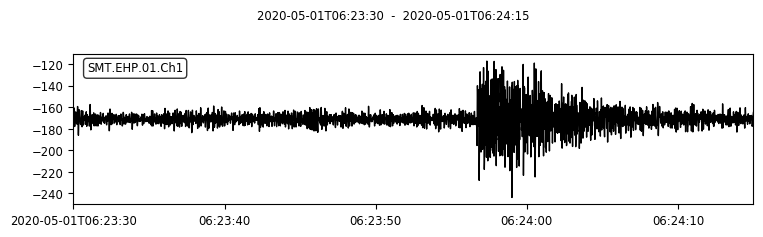

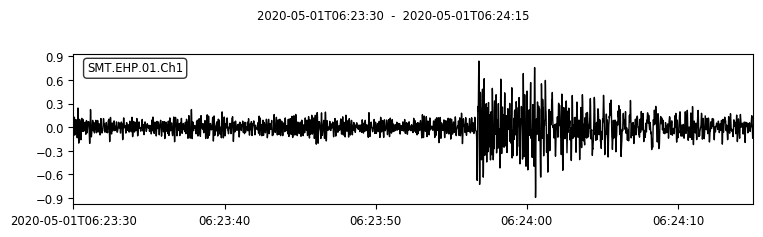

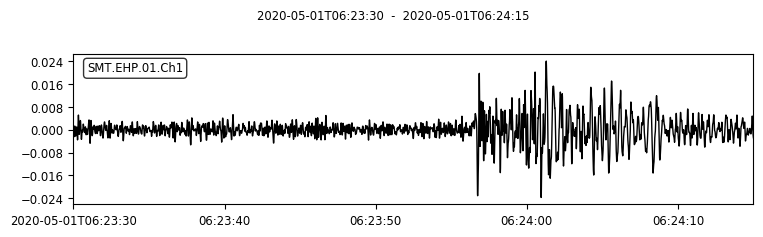

{'station': 'EHP',
 'Pd': 0.024111240852022507,
 'PGV_true': 0.89347686957649253,
 'PGV_cal': 1.4244329014396149,
 'intensity_true': '1',
 'intensity_cal': '2'}

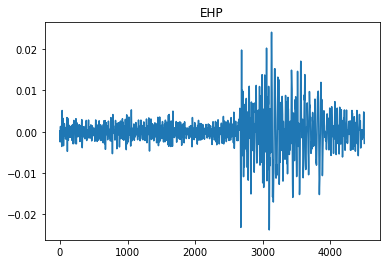

In [24]:
st_Pd_PGV_I(st_list_cut[0])

,station,Pd,PGV_true,PGV_cal,intensity_true,intensity_cal
0,EHP,0.024111,0.893477,1.424433,1,2
1,ENT,0.010347,0.533479,0.654081,1,1
2,ESA,0.082248,4.946434,4.404673,2,3
3,ETL,0.005969,0.227041,0.394332,1,1
4,ETLH,0.006127,0.518884,0.403889,1,1
5,NDS,0.016331,1.289289,0.995333,2,2
6,NDT,0.006341,0.408260,0.416829,1,1
7,NNS,0.001577,0.346726,0.115884,1,0
8,TWC,0.017287,1.235356,1.048805,2,2


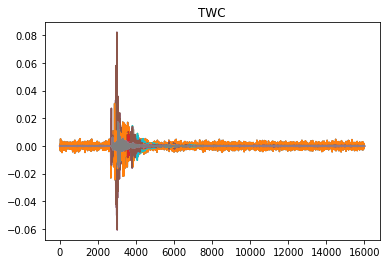

In [20]:
#寫成pandas
scores=[]
for i in st_list:
    scores.append(st_Pd_PGV_I(i))
    st_Pd_PGV_I(i)
    df1 = pd.DataFrame(scores)
df1


In [15]:
#讀取測站資料
with open("c:\\datasrc\\hypo3d.sta","r") as fp:
    fp.readline()
    stalist=fp.readlines()

In [16]:
#讀取測站經緯
stainfo={}
for i in stalist:
    i=i.strip()
    #print(i)

    lat_d = float(i[4:6])
    lat_m = float(i[6:11])
    lon_d = float(i[11:14])
    lon_m = float(i[14:19])

    lat = lat_d + lat_m/60.0
    lon = lon_d + lon_m/60.0
    sta = i.split()[-1]
    stainfo[sta]=[lon , lat]
    

In [17]:
sta_lalon={}
for i in df1['station']:
    if i in stainfo.keys():
        sta_lalon[i]=stainfo[i]
sta_lalon['ESA']=[121.8439,24.5757]


In [18]:
#將測站經緯寫成txt檔
with open("lonlat.txt","w") as fp:
    for i in sta_lalon.keys():
        fp.write(str(sta_lalon[i][0])+" "+str(sta_lalon[i][1])+"\n")

In [19]:
#將地震經緯寫成txt檔
with open("E_lonlat.txt","w") as fp:
    ff=str(Pfile["lon"])+" "+str(Pfile["lat"])
    fp.write(ff)

In [20]:
##將測站震度寫成txt檔
with open("intensity.txt","w") as fp:
    j==0
    for i in sta_lalon.keys():
        fp.write(str(sta_lalon[i][0])+" "+str(sta_lalon[i][1]-0.02)+" "+"("+str(df1.iloc[j,4])+","+str(df1.iloc[j,5])+")"+"\n")
        j=j+1
        

In [21]:
with open("1119plot.bat","w") as fp:
    fp.write("gmt begin 1119_U10710019 png \n")
    fp.write("    gmt psbasemap -R121/122.2/24/24.8 -JM6i -Ba1f0.5 \n")
    fp.write("    gmt plot TaiwanCOunty.gmt -R121/122.2/24/24.8 -JM6i \n")
    fp.write("    gmt plot lonlat.txt -R121/122.2/24/24.8 -St0.5 -G255/255/0 \n")
    fp.write("    gmt plot E_lonlat.txt -R121/122.2/24/24.8 -Sa0.5 -G255/0/0  \n")
    fp.write("    gmt text intensity.txt -R121/122.2/24/24.8  \n")
    fp.write("gmt end show")
    



In [21]:
os.system("1119plot.bat")

0